In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utils.utils import convert_action

website to find .csv:

In [2]:
df = pd.read_csv('./data/AAPL.csv', index_col=0)
# df['Date'] = pd.to_datetime(df.Date, format="%d/%m/%Y")
# df = df.sort_values('Date')
# df.to_csv('./data/AAPL.csv')

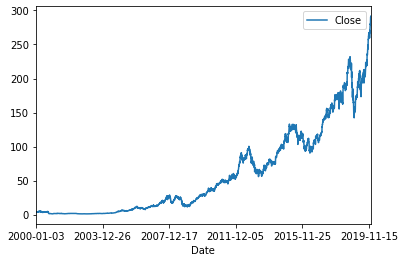

In [3]:
df.plot(x="Date", y="Close")

In [4]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-01-03,3.745536,4.017857,3.631696,3.997768,3.478462,133949200
1,2000-01-04,3.866071,3.950893,3.613839,3.660714,3.185191,128094400
2,2000-01-05,3.705357,3.948661,3.678571,3.714286,3.231803,194580400
3,2000-01-06,3.790179,3.821429,3.392857,3.392857,2.952128,191993200
4,2000-01-07,3.446429,3.607143,3.410714,3.553571,3.091966,115183600


## Let the DQN trade

In [5]:
from networks.DQN import MyModel
from env.StockTradingEnv import StockTradingEnv
import tensorflow as tf

from tensorflow.keras.models import load_model

### Parameters of the DQN model (taken from main_with_dqn)

In [6]:
df = pd.read_csv('./data/AAPL.csv')
df = df.sort_values('Date')
env = StockTradingEnv(df)

num_actions = 3
hidden_units = [200, 200]
input_shape = env.observation_space.sample().shape

path_weights_200 = "save_models/DQN_200" # last number is number of episodes trained
path_weights_400 = "save_models/DQN_400"
path_weights_1000 = "save_models/DQN_1000"

### Build the Agent

In [7]:
class TradingAgent():
    """A class to simplify the trading decisions"""
    def __init__(self, model, path_weights, name):
        self.model = model
        self.model.load_weights(path_weights)
        self.name = name # name of the agent
    
    def get_action(self, state): #meant for only a single state for input
        prediction = self.model.predict(state)
        return np.argmax(prediction[0])

In [8]:
trade_model_200 = MyModel(input_shape, hidden_units, num_actions)
trade_model_400 = MyModel(input_shape, hidden_units, num_actions)
trade_model_1000 = MyModel(input_shape, hidden_units, num_actions)

# trade_model.load_weights(path_weights)
Agent_200 = TradingAgent(trade_model_200, path_weights_200, "agent200")
Agent_400 = TradingAgent(trade_model_400, path_weights_400, "agent400")
Agent_1000 = TradingAgent(trade_model_1000, path_weights_1000, "agent1000")

agents = [Agent_200, Agent_400, Agent_1000]

### Run over the data frame

In [9]:
df = pd.read_csv('./data/AAPL.csv')
df = df.sort_values('Date')

df_results = pd.DataFrame(columns=['Date','Index', 'agent200', 'agent400', 'agent1000'], index=df.index)
df_results['Date'] = df['Date']

# Compute the Index value
for i in range(len(df.loc[:, 'Open'].values) - 6):
    df_results.loc[i+5, "Index"] = df.loc[i+5, "Close"] * env.initial_account_balance / df.loc[5, "Close"] # i + 5 because of the format of the data
    
# Compute the Agents' net_worth
for Agent in agents:
    env = StockTradingEnv(df)
    observation = env.reset_to_day_one().reshape(1,6,6).astype('float32') # necessary to reshape each observation
    
    for i in range(len(df.loc[:, 'Open'].values) - 6):
        action = Agent.get_action(observation.reshape(1,6,6).astype('float32'))
        action = convert_action(action)
        observation, reward, done, _ = env.step(action)

        df_results.loc[i+5, Agent.name] = env.net_worth

        print("\r {}, day {} out of {}".format(Agent.name, i, len(df.loc[:, 'Open'].values) - 7), end = "")
    print("")
    
print("last net_worth: {}".format(env.net_worth))

 agent200, day 5023 out of 5023
 agent400, day 5023 out of 5023
 agent1000, day 5023 out of 5023
last net_worth: 758485.7784663658


### Visualize the results

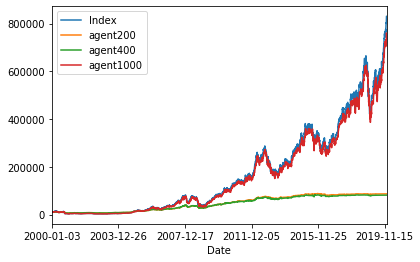

In [10]:
df_results.plot(x="Date", y=["Index", "agent200", "agent400", "agent1000"])

In [11]:
env.initial_account_balance

10000